<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/TF_GAN_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Check that imports for the rest of the file work.
import tensorflow as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline

     |████████████████████████████████| 368kB 339kB/s 



In [3]:
#imports for the generator & duscrminator defned via keras layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
# keras module inside tf, hopefully it'll work the same way keras works....
from tensorflow import keras
from tensorflow.keras import layers

In [0]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy import vstack

## Overview

This colab will walk you through the basics of using [TF-GAN](https://github.com/tensorflow/gan) to define, train, and evaluate Generative Adversarial Networks (GANs). We describe the library's core features as well as some extra features. This colab assumes a familiarity with TensorFlow's Python API. For more on TensorFlow, please see [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

## Learning objectives

In this Colab, you will learn how to:
*   Use TF-GAN Estimators to quickly train a GAN

## Unconditional MNIST with GANEstimator

This exercise uses TF-GAN's GANEstimator and the MNIST dataset to create a GAN for generating fake handwritten digits.

### MNIST

The [MNIST dataset](https://wikipedia.org/wiki/MNIST_database) contains tens of thousands of images of handwritten digits. We'll use these images to train a GAN to generate fake images of handwritten digits. This task is small enough that you'll be able to train the GAN in a matter of minutes.

### GANEstimator

TensorFlow's Estimator API that makes it easy to train models. TF-GAN offers `GANEstimator`, an Estimator for training GANs.

### Input Pipeline using tf.dataset

We set up our input pipeline by defining an `input_fn`. in the "Train and Eval Loop" section below we pass this function to our GANEstimator's `train` method to initiate training.  The `input_fn`:

1.  Generates the random inputs for the generator.
2.  Uses `tensorflow_datasets` to retrieve the MNIST data.
3.  Uses the tf.data API to format the data.

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random_normal([bs, nd])))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

Download the data and sanity check the inputs.

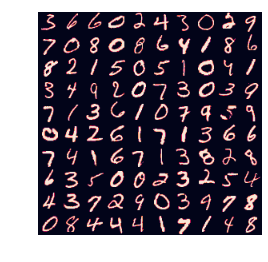

In [0]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import numpy as np

params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(tfds.as_numpy(ds))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()

# Keras based pipeline

11493376/11490434 [==============================] - 1s 0us/step


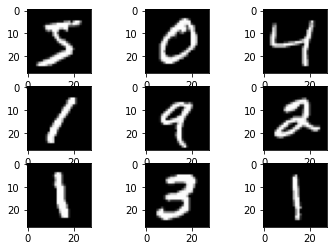

In [6]:
# Interinm use of Keras mnist (before switiching to tf dataset up above)
(x_train, _), (x_test, _) = mnist.load_data()

# plot first few images as a sanity check
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### Neural Network Architecture (assumes using tf.dataset & tensorflow-gan)

To build our GAN we need two separate networks:

*  A generator that takes input noise and outputs generated MNIST digits
*  A discriminator that takes images and outputs a probability of being real or fake

We define functions that build these networks. In the GANEstimator section below we pass the builder functions to the `GANEstimator` constructor. `GANEstimator` handles hooking the generator and discriminator together into the GAN. 


In [0]:
def _dense(inputs, units, l2_weight):
  return tf.layers.dense(
      inputs, units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _batch_norm(inputs, is_training):
  return tf.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.layers.conv2d_transpose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=tf.nn.relu, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=None, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

In [0]:
def unconditional_generator(noise, mode, weight_decay=2.5e-5):
  """Generator to produce unconditional MNIST images."""
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _dense(noise, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = _dense(net, 7 * 7 * 256, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = tf.reshape(net, [-1, 7, 7, 256])
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  # Make sure that generator output is in the same range as `inputs`
  # ie [-1, 1].
  net = _conv2d(net, 1, 4, 1, 0.0)
  net = tf.tanh(net)

  return net

In [0]:
_leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def unconditional_discriminator(img, unused_conditioning, mode, weight_decay=2.5e-5):
  del unused_conditioning
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _conv2d(img, 64, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = _conv2d(net, 128, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = tf.layers.flatten(net)
  
  net = _dense(net, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = _leaky_relu(net)
  
  net = _dense(net, 1, weight_decay)

  return net

# Keras based implementation

In [7]:
#alternative generator impementation using keras:
def build_generator():

    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    latent_dim = 100
    model.add(Dense(n_nodes, input_dim=latent_dim))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

    return model
gen = build_generator()
gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 28, 28, 128)      

In [0]:
# checking the untrained generator
from numpy import zeros
from numpy.random import randn
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

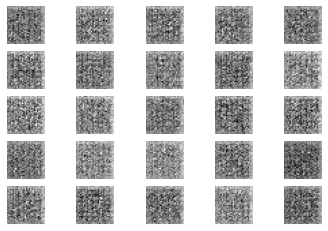

In [12]:
# test generator
# size of the latent space
latent_dim = 100
# define the discriminator model
# generate samples
n_samples = 25
X, _ = generate_fake_samples(gen, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

In [13]:
# alternative discriminator model
def build_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
dscr = build_discriminator()
# summarize the model
dscr.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

In [0]:
# Generate some fake data to see how the descriminator works:
def generate_fakes(n_samples):
	# generate uniform random numbers in [0,1]
	X_fake = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X_fake = X_fake.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y_fake = zeros((n_samples, 1))
	return X_fake, y_fake

In [0]:
# get some real data samples
def generate_real_samples(x_train, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X_real = dataset[ix]
	# generate 'real' class labels (1)
	y_real = ones((n_samples, 1))
	return X_real, y_real

In [30]:
# test descriminator:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=30, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fakes(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
  
# Use dscr from above
# load image data
dataset = x_train
# fit the model
train_discriminator(dscr, dataset)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1 real=100% fake=100%
>2 real=100% fake=100%
>3 real=100% fake=100%
>4 real=100% fake=100%
>5 real=100% fake=100%
>6 real=100% fake=100%
>7 real=100% fake=100%
>8 real=100% fake=100%
>9 real=100% fake=100%
>10 real=100% fake=100%
>11 real=100% fake=100%
>12 real=100% fake=100%
>13 real=100% fake=100%
>14 real=100% fake=100%
>15 real=100% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%
>21 real=100% fake=100%
>22 real=100% fake=100%
>23 real=100% fake=100%
>24 real=100% fake=100%
>25 real=100% fake=100%
>26 real=100% fake=100%
>27 real=100% fake=100%
>28 real=100% fake=100%
>29 real=100% fake=100%
>30 real=100% fake=100%


### Evaluating Generative Models, and evaluating GANs (using Tensorlow-gan)


TF-GAN provides some standard methods of evaluating generative models. In this example, we measure:

*  Inception Score: called `mnist_score` below.
*  Frechet Inception Distance

We apply a pre-trained classifier to both the real data and the generated data calculate the *Inception Score*.  The Inception Score is designed to measure both quality and diversity. See [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) by Salimans et al for more information about the Inception Score.

*Frechet Inception Distance* measures how close the generated image distribution is to the real image distribution.  See [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) by Heusel et al for more information about the Frechet Inception distance.

In [0]:
from tensorflow_gan.examples.mnist import util as eval_util
import os

def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  real_mnist_score = eval_util.mnist_score(gan_model.real_data)
  generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
  frechet_distance = eval_util.mnist_frechet_distance(
      gan_model.real_data, gan_model.generated_data)
  return {
      'real_data_logits': tf.metrics.mean(real_data_logits),
      'gen_data_logits': tf.metrics.mean(gen_data_logits),
      'real_mnist_score': tf.metrics.mean(real_mnist_score),
      'mnist_score': tf.metrics.mean(generated_mnist_score),
      'frechet_distance': tf.metrics.mean(frechet_distance),
  }

# GAN Model (option 1)

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [15]:
# create the gan
gan_model = define_gan(gen, dscr)
# summarize gan model
gan_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


**GAN Training**

In [0]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      d_loss, _ = d_model.train_on_batch(X, y)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      #print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    if (i+1)%10 == 0:
      print('>%d, d=%.3f, g=%.3f' % (i+1, d_loss, g_loss))
      show_plot(X_fake)

In [0]:
#plot generated images:
def show_plot(examples, n=10):
	# plot images
	for i in range(n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/273, d=0.686, g=0.729
>1, 2/273, d=0.685, g=0.738
>1, 3/273, d=0.683, g=0.738
>1, 4/273, d=0.674, g=0.727
>1, 5/273, d=0.683, g=0.729
>1, 6/273, d=0.681, g=0.718
>1, 7/273, d=0.681, g=0.707
>1, 8/273, d=0.678, g=0.695
>1, 9/273, d=0.686, g=0.682
>1, 10/273, d=0.679, g=0.693
>1, 11/273, d=0.691, g=0.685
>1, 12/273, d=0.683, g=0.689
>1, 13/273, d=0.691, g=0.703
>1, 14/273, d=0.687, g=0.713
>1, 15/273, d=0.688, g=0.714
>1, 16/273, d=0.691, g=0.713
>1, 17/273, d=0.688, g=0.706
>1, 18/273, d=0.695, g=0.700
>1, 19/273, d=0.687, g=0.690
>1, 20/273, d=0.699, g=0.688
>1, 21/273, d=0.699, g=0.692
>1, 22/273, d=0.697, g=0.687
>1, 23/273, d=0.691, g=0.684
>1, 24/273, d=0.693, g=0.693
>1, 25/273, d=0.694, g=0.700
>1, 26/273, d=0.696, g=0.693
>1, 27/273, d=0.695, g=0.704
>1, 28/273, d=0.690, g=0.708
>1, 29/273, d=0.695, g=0.714
>1, 30/273, d=0.691, g=0.703
>1, 31/273, d=0.692, g=0.704
>1, 32/273, d=0.695, g=0.700
>1, 33/273, d=0.687, g=0.689
>1, 34/273, d=0.683, g=0.698
>1, 35/273, d=0.681, g=

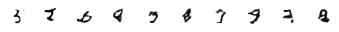

>11, 1/273, d=0.690, g=0.725
>11, 2/273, d=0.694, g=0.681
>11, 3/273, d=0.686, g=0.659
>11, 4/273, d=0.685, g=0.655
>11, 5/273, d=0.690, g=0.690
>11, 6/273, d=0.686, g=0.730
>11, 7/273, d=0.691, g=0.736
>11, 8/273, d=0.688, g=0.721
>11, 9/273, d=0.688, g=0.696
>11, 10/273, d=0.683, g=0.675
>11, 11/273, d=0.692, g=0.692
>11, 12/273, d=0.690, g=0.721
>11, 13/273, d=0.689, g=0.732
>11, 14/273, d=0.685, g=0.722
>11, 15/273, d=0.687, g=0.711
>11, 16/273, d=0.692, g=0.689
>11, 17/273, d=0.676, g=0.684
>11, 18/273, d=0.687, g=0.696
>11, 19/273, d=0.688, g=0.704
>11, 20/273, d=0.689, g=0.714
>11, 21/273, d=0.689, g=0.705
>11, 22/273, d=0.691, g=0.710
>11, 23/273, d=0.689, g=0.701
>11, 24/273, d=0.681, g=0.686
>11, 25/273, d=0.678, g=0.692
>11, 26/273, d=0.684, g=0.705
>11, 27/273, d=0.687, g=0.719
>11, 28/273, d=0.685, g=0.717
>11, 29/273, d=0.689, g=0.704
>11, 30/273, d=0.695, g=0.693
>11, 31/273, d=0.685, g=0.682
>11, 32/273, d=0.684, g=0.690
>11, 33/273, d=0.689, g=0.723
>11, 34/273, d=0.68

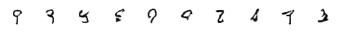

>21, 1/273, d=0.684, g=0.670
>21, 2/273, d=0.685, g=0.704
>21, 3/273, d=0.682, g=0.739
>21, 4/273, d=0.696, g=0.748
>21, 5/273, d=0.691, g=0.707
>21, 6/273, d=0.680, g=0.703
>21, 7/273, d=0.688, g=0.708
>21, 8/273, d=0.684, g=0.748
>21, 9/273, d=0.681, g=0.733
>21, 10/273, d=0.684, g=0.713
>21, 11/273, d=0.693, g=0.696
>21, 12/273, d=0.693, g=0.682
>21, 13/273, d=0.684, g=0.682
>21, 14/273, d=0.686, g=0.702
>21, 15/273, d=0.689, g=0.725
>21, 16/273, d=0.686, g=0.739
>21, 17/273, d=0.691, g=0.726
>21, 18/273, d=0.679, g=0.700
>21, 19/273, d=0.682, g=0.685
>21, 20/273, d=0.694, g=0.685
>21, 21/273, d=0.693, g=0.707
>21, 22/273, d=0.693, g=0.751
>21, 23/273, d=0.682, g=0.745
>21, 24/273, d=0.699, g=0.702
>21, 25/273, d=0.689, g=0.665
>21, 26/273, d=0.683, g=0.673
>21, 27/273, d=0.691, g=0.692
>21, 28/273, d=0.680, g=0.701
>21, 29/273, d=0.681, g=0.707
>21, 30/273, d=0.682, g=0.724
>21, 31/273, d=0.682, g=0.739
>21, 32/273, d=0.685, g=0.745
>21, 33/273, d=0.688, g=0.723
>21, 34/273, d=0.69

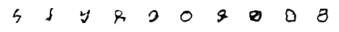

In [23]:
# size of the latent space
latent_dim = 100
# load image data
dataset = vstack((x_train, x_test))
# train model
train(gen, dscr, gan_model, dataset, latent_dim)

# Tensorflow-gan

### GANEstimator - Using Tensorflow-gan

The `GANEstimator` assembles and manages the pieces of the whole GAN model. The `GANEstimator` constructor takes the following compoonents for both the generator and discriminator:

*  Network builder functions: we defined these in the "Neural Network Architecture" section above.
*  Loss functions: here we use the wasserstein loss for both.
*  Optimizers: here we use `tf.train.AdamOptimizer` for both generator and discriminator training.

In [0]:
train_batch_size = 32 #@param
noise_dimensions = 64 #@param
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param

def gen_opt():
  gstep = tf.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.train.AdamOptimizer(lr, 0.5)

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=unconditional_generator,
    discriminator_fn=unconditional_discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer=gen_opt,
    discriminator_optimizer=tf.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

### Train and eval loop - Using Tensorflow-gan

The `GANEstimator`'s `train()` method initiates GAN training, including the alternating generator and discriminator training phases.

The loop in the code below calls `train()` repeatedly in order to periodically display generator output and evaluation results. But note that the code below does not manage the alternation between discriminator and generator: that's all handled automatically by `train()`.

Time since start: 0.32 min
Trained from step 0 to 500 in 25.67 steps / sec
Average discriminator output on Real: -10.51  Fake: -10.17
Inception Score: 5.97 / 8.38  Frechet Distance: 98.58


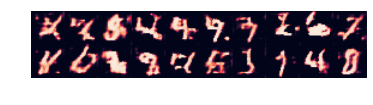

Time since start: 0.69 min
Trained from step 500 to 1000 in 33.82 steps / sec
Average discriminator output on Real: -6.00  Fake: -5.53
Inception Score: 6.61 / 8.38  Frechet Distance: 69.39


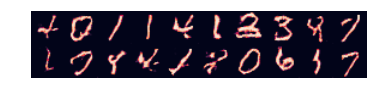

Time since start: 1.05 min
Trained from step 1000 to 1500 in 33.28 steps / sec
Average discriminator output on Real: -20.26  Fake: -20.98
Inception Score: 7.15 / 8.38  Frechet Distance: 58.26


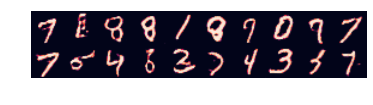

Time since start: 1.43 min
Trained from step 1500 to 2000 in 29.00 steps / sec
Average discriminator output on Real: -28.74  Fake: -29.66
Inception Score: 7.35 / 8.38  Frechet Distance: 54.52


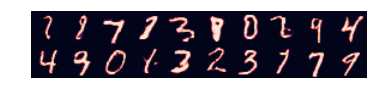

Time since start: 1.79 min
Trained from step 2000 to 2500 in 33.04 steps / sec
Average discriminator output on Real: -27.47  Fake: -28.54
Inception Score: 7.17 / 8.38  Frechet Distance: 62.29


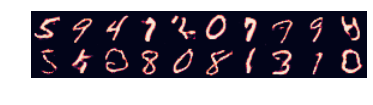

Time since start: 2.14 min
Trained from step 2500 to 3000 in 33.26 steps / sec
Average discriminator output on Real: 1.75  Fake: 2.23
Inception Score: 7.38 / 8.38  Frechet Distance: 55.90


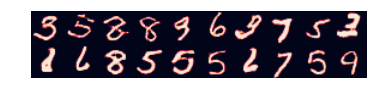

Time since start: 2.51 min
Trained from step 3000 to 3500 in 31.49 steps / sec
Average discriminator output on Real: -2.78  Fake: -13.50
Inception Score: 7.38 / 8.38  Frechet Distance: 58.81


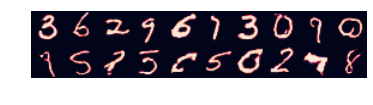

Time since start: 2.86 min
Trained from step 3500 to 4000 in 32.85 steps / sec
Average discriminator output on Real: 84.46  Fake: 79.25
Inception Score: 7.63 / 8.38  Frechet Distance: 56.05


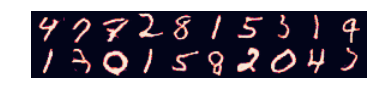

Time since start: 3.20 min
Trained from step 4000 to 4500 in 33.85 steps / sec
Average discriminator output on Real: 139.49  Fake: 130.57
Inception Score: 7.48 / 8.38  Frechet Distance: 59.30


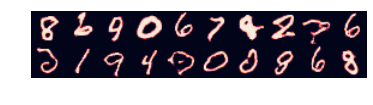

Time since start: 3.58 min
Trained from step 4500 to 5000 in 32.00 steps / sec
Average discriminator output on Real: 197.43  Fake: 191.78
Inception Score: 7.44 / 8.38  Frechet Distance: 55.80


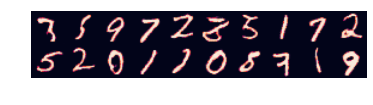

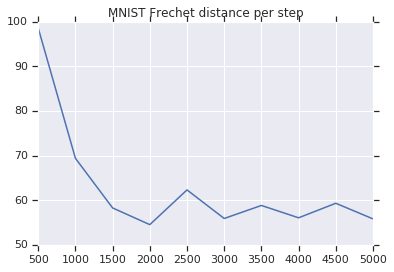

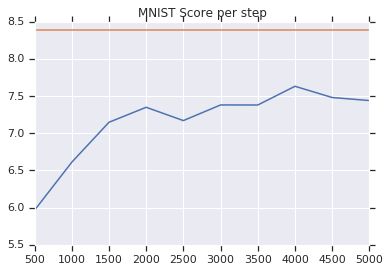

In [0]:
# Disable noisy output.
tf.autograph.set_verbosity(0, False)

import time
steps_per_eval = 500 #@param
max_train_steps = 5000 #@param
batches_for_eval_metrics = 100 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()
  
  
# Plot the metrics vs step.
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title('MNIST Score per step')
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()

### Next steps

Try [this colab notebook](https://github.com/tensorflow/gan) to train a GAN on Google's Cloud TPU use TF-GAN.


